# Closed-loop experimentation with active learning

In order to use modAL for our response time experiment, we have to rethink modAL's workflow a little bit.

In the standard use-case of active learning we have a bunch of unlabelled samples (e.g. images) which we want to label by *experts* (e.g. telling the shown image contains either a tiger or a dog).

In the case of optimal experimental design, we don't have to collect these samples a-priori but we can determine the most promising conditions and let the participant give its label by giving us the corresponding response (observation). We are therefore able to collect new samples on the fly.

This leads us to the last part of the course, i.e. the implementation of a closed-loop experiment.

Here, we will use the automated research assistant (AutoRA) framework to set up the automated closed-loop experiment. The following image shows the general autora workflow.

![static/img/autora_workflow.png](static/img/autora_workflow.png)

(Image source: [autora](https://autoresearch.github.io/autora/))

AutoRA connects three components to enable closed-loop research, i.e. an experiment runner (executing our response time experiment), a theorist fitting a model to explain the observations (our neural network regressor), and finally an experimentalist coming up with new interesting conditions (the active learning algorithm). Further components of this framework are the integration of more services e.g. online experimentation platforms (e.g. firebase), online recruitement platforms (e.g. prolific) and database platforms. 

Fortunately, the framework was created with maximum flexibility in mind. Therefore we can integrate our components quite easily into the autora workflow.

Let's start doing that!

## Library imports

In [1]:
import sys, os

import numpy as np
import pandas as pd
from skorch import NeuralNetRegressor

from autora.state import StandardState, on_state, estimator_on_state
from autora.experimentalist.random import random_pool
from autora.theorist.bms import BMSRegressor

# Set the path to the project folder
target_folder = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Adjust path as needed
if target_folder not in sys.path:
    sys.path.append(target_folder)
    
from resources.regressors import FFN

## Experiment runner

The experiment runner works with independent and dependent variables. These are conditions which can be set independently and observations which depend on the conditions.
We will use the random sampler to identify initial conditions.

In [2]:
# basic experiment parameters

n_units = 100

noise_level = 0.

parameters = np.random.normal(1., 0.5, (n_units, 2))

In [3]:
from resources.synthetic import twoafc

In [4]:
help(twoafc)

Help on function twoafc in module resources.synthetic:

twoafc(parameters: numpy.ndarray, name='2AFC', resolution=100, minimum_value_condition: float = 0.0, maximum_value_condition: float = 1.0)
    2AFC experiment with two independent variables
    
    Args:
        parameters: abstract parameters for the underlying ground truth model; must be an array of shape (n_units, 2)
        name: name of the experiment
        resolution: number of allowed values for stimulus
        Examples:
        >>> s = twoafc()
        >>> s.run(np.array([[.2,.1]]), random_state=42)
            participant id  ratio   scatteredness   response time
        0   0               1.0     1.0             1.592393




    2AFC experiment with two independent variables

    Args:
        parameters: abstract parameters for the underlying ground truth model; must be an array of shape (n_units, 2)
        name: name of the experiment
        resolution: number of allowed values for stimulus
        Examples:
        >>> s = twoafc()
        >>> s.run(np.array([[.2,.1]]), random_state=42)
            participant id  ratio   scatteredness   response time
        0   0               1.0     1.0             1.592393
    


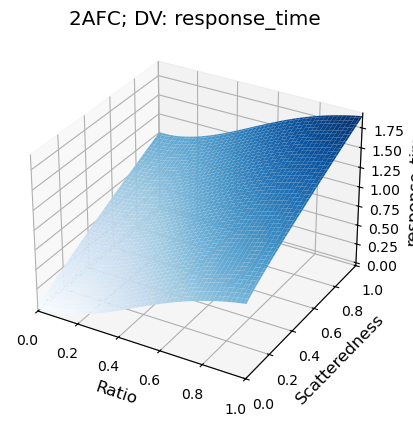

In [5]:
from autora.experiment_runner.synthetic.utilities import describe

s = twoafc(parameters)
print(describe(s))

s.run(np.array([[0, 1, 1]]), random_state=42)
s.plotter()

## Theorist

## Experimentalist

## Loop

When starting our loop, we first have to determine some initial conditions.

For simplicity we will use here a uniform random sampler to generate the intital conditions. 

You should use a latin hypercube sampler in your code instead

In [18]:
from resources.sampler import random_sampler

#### Define experiment runner and wrap with state functionality ####
experiment = twoafc(parameters)

#### Define experimentalist and wrap with state functionality ####
experimentalist = random_sampler

#### Define theorist and wrap with state functionality ####
theorist = NeuralNetRegressor(FFN(n_units, 2), max_epochs=100, lr=0.1, batch_size=1024)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1           nan           nan  0.6991
      2           nan           nan  0.8227
      3           nan           nan  0.8002
      4           nan           nan  0.6561
      5           nan           nan  0.6234
      6           nan           nan  0.7564


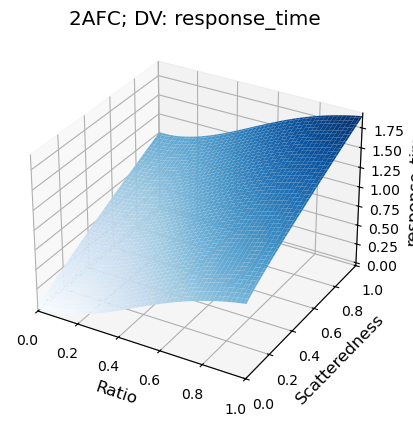

In [19]:
for cycle in range(1):
    conditions = experimentalist(experiment.variables, num_samples=1000, random_state=42, sample_all=['participant_id']).values
    
    dataset = experiment.run(conditions, added_noise=0.5, random_state=42+cycle)
    observations = dataset[[dv.name for dv in experiment.variables.dependent_variables]].values
    
    theorist.fit(conditions.astype(np.float32), observations.astype(np.float32))
    
experiment.plotter(theorist)